# Example: fitting a curve to data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.integrate

%matplotlib inline

Given some **position v. time** data, and we want to know if the object was moving at constant velocity or accelerating.

**constant velocity:**

$$x(t) = x_0 + v_0 t$$


**constant accleration:**

$$x(t) = x_0 + v_0 t + \frac{1}{2} a_0 t^2$$


## simulate data

Our position measuring instrument has measurement uncertainty at the 4 cm level.

We start the object at $x_0 = 0$.

In [2]:
def pos_v_time(t, x0=0, v0=0, a0=0):
    """position of object undergoing constant acceleration"""
    ts = np.asarray(t)
    xs = x0 + v0*ts + 0.5*a0*ts**2
    return xs

In [3]:
T = 3.0  # length of data (sec)
dx = 4  # cm of meas uncert
x0 = 0
v0 = 24  # cm/s
a0 = 6  # cm/s^2

ts = np.arange(0, T, 0.2)
xs = pos_v_time(ts, x0, v0, a0)
N = len(ts)

uncert = np.random.normal(scale=dx, size=N)

x_dat = xs + uncert
x_dat[0] = 0  # x=0 defined!

In [4]:
#np.savetxt('xvt.dat', x_dat)
x_dat = np.loadtxt('xvt.dat')

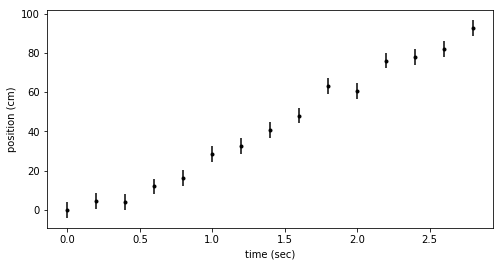

In [5]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.errorbar(ts, x_dat, yerr=dx, fmt=".k")
ax.set_xlabel('time (sec)')
ax.set_ylabel('position (cm)');

## constant velocity (linear) model

$x_0 = 0$ by definition, so there is **one free parameter**, $v$

### marginalize over nuisance param $v$
$$p\left(d \mid \mathcal{H}_v \right) = \int \mathrm{d}v \, p\left(v \mid \mathcal{H}_v \right)\, p\left( d \mid \mathcal{H}_v, v \right)$$

### calculate likelihood as function of $v$
$$m_i = x_i = v\, t_i$$

$$p\left(d \mid \mathcal{H}_v, v \right) = \left(\frac{1}{\sqrt{2\pi}\,\sigma}\right)^N \exp\left(- \frac{(d_i-m_i)^2}{2{\sigma}^2}\right)$$

### assume uniform prior for $v \in [0,50]$
$$p\left(v \mid \mathcal{H}_v \right) = \frac{1}{\Delta v} = \frac{1}{50}$$

In [6]:
def prob_line(v, dat):
    """posterior prob(v) for line model
    Gaussian likelihood
    uniform prior on v [0,50]
    """
    N = len(dat)
    if v<0 or v>50:
        return 0
    else:
        prior = 1/50
    
    mod = pos_v_time(ts, x0=0, v0=v, a0=0)
    norm = (np.sqrt(2*np.pi)*dx)**-N
    arg = -0.5*np.sum((dat - mod)**2)/dx**2
    like = norm * np.exp(arg)
    
    return prior * like

## integrate over $v$ to compute the marginal likelihood

In [7]:
vs = np.linspace(0, 50, 200)

integrand = [prob_line(v, x_dat) for v in vs]
pline = scipy.integrate.simps(integrand, vs)  # simpson's integrater!
print(pline)

2.7465509062754537e-22


## determine best fit line

We can use the posterior probability for $v$ to determine best fit parameter.

First, we form the CDF, then determine the median and 90% CI

In [8]:
pdf_line = integrand/pline  # normalize!
dv = vs[1]-vs[0]
cdf_line = np.cumsum(pdf_line)*dv

idx = cdf_line.searchsorted([0.5, 0.05, 0.95])
v_med, v_5, v_95 = vs[idx]
print("median = {0:.2f},  90% CI = ({1:.2f} - {2:.2f})".format(v_med, v_5, v_95))

bestfit_line = pos_v_time(ts, x0=0, v0=v_med, a0=0)

median = 31.66,  90% CI = (30.65 - 32.66)


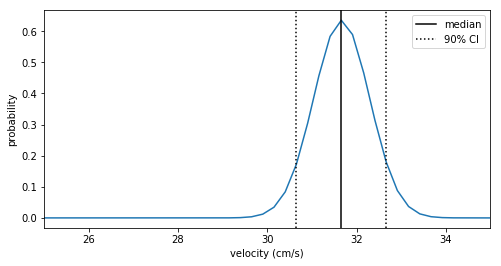

In [9]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(111)
ax1.plot(vs, pdf_line)
ax1.set_xlabel("velocity (cm/s)")
ax1.axvline(x=v_med, color = 'k', label='median')
ax1.axvline(x=v_5, color = 'k', linestyle=':', label=r'90% CI')
ax1.axvline(x=v_95, color = 'k', linestyle=':')
ax1.set_ylabel('probability')
ax1.set_xlim([25, 35])
ax1.legend();

## Best fit line

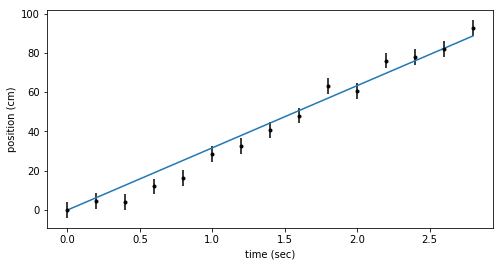

In [10]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.errorbar(ts, x_dat, yerr=dx, fmt=".k")
ax.plot(ts, bestfit_line, color='C0')
ax.set_xlabel('time (sec)')
ax.set_ylabel('position (cm)');

## constant acceleration (quadratic) model

again $x_0 = 0$, so there are **two free parameter**, $v$ and $a$

### marginalize over all nuisance params
$$p\left(d \mid \mathcal{H}_a \right) = \int \mathrm{d}v\,\mathrm{d}a \, p\left(v \mid \mathcal{H}_a \right)\, p\left(a \mid \mathcal{H}_a \right)\, p\left( d \mid \mathcal{H}_a, v, a \right)$$

### Gaussian likelihood as function of $v$ and $a$
$$m_i = x_i = v\, t_i + \frac{1}{2} a\, {t_1}^2$$

$$p\left(d \mid \mathcal{H}_a, v, a \right) = \left(\frac{1}{\sqrt{2\pi}\,\sigma}\right)^N \exp\left(- \frac{(d_i-m_i)^2}{2{\sigma}^2}\right)$$

### assume uniform priors for $v \in [0,50]$ and $a \in [-5,15]$
$$p\left(v \mid \mathcal{H}_a \right) = \frac{1}{\Delta v} = \frac{1}{50}, \quad\quad
p\left(a \mid \mathcal{H}_a \right) = \frac{1}{\Delta a} = \frac{1}{20}$$

In [11]:
def prob_quad(params, dat):
    """posterior prob(v,a) for quadratic model
    Gaussian likelihood for params
    uniform prior on v [0,50]
    uniform prior on a [-5,15]
    """
    N = len(dat)
    v, a = params
    if v<0 or v>50 or a<-5 or a>15:
        return 0
    else:
        prior = 1/50 * 1/20  # p(v)*p(a)
    
    mod = pos_v_time(ts, x0=0, v0=v, a0=a)
    norm = (np.sqrt(2*np.pi)*dx)**-N
    arg = -0.5*np.sum((dat - mod)**2)/dx**2
    like = norm * np.exp(arg)
        
    return prior * like

## integrate over $v$ and $a$ to compute the marginal likelihood

In [12]:
vs = np.linspace(0, 50, 200)
As = np.linspace(-5, 15, 200)

prob_pts = np.zeros((len(vs), len(As)))
for ii, v in enumerate(vs):
    for jj, a in enumerate(As):
        prob_pts[ii,jj] = prob_quad([v,a], x_dat)

In [13]:
int_a = scipy.integrate.simps(prob_pts, x=As, axis=0)
int_v = scipy.integrate.simps(int_a, x=vs)
pquad = int_v
print(pquad)

9.997731977662011e-21


## compute the odds ratio for the acceleration model

In [14]:
Odds = pquad/pline
prob = 1/(1 + 1/Odds)
print("Oquad = {0:.0f};  prob = {1:.4f}".format(Odds, prob))

Oquad = 36;  prob = 0.9733


## the posterior for $v$ and $a$ is 2D

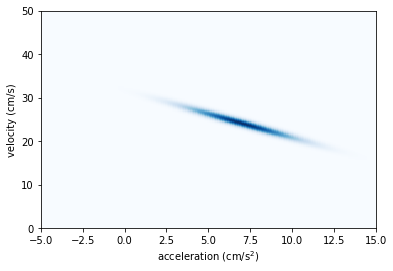

In [15]:
plt.pcolormesh(As, vs, prob_pts, cmap='Blues')
plt.xlabel("acceleration (cm/s$^2$)")
plt.ylabel("velocity (cm/s)");

## Determin best fit parameters from PDF and CDF

In [16]:
apost = scipy.integrate.simps(prob_pts, x=As, axis=0)
vpost = scipy.integrate.simps(prob_pts, x=vs, axis=1)

a_cdf = np.cumsum(apost) / np.sum(apost)  # normalize
v_cdf = np.cumsum(vpost) / np.sum(vpost)

idx_a = a_cdf.searchsorted([0.5, 0.05, 0.95])
idx_v = v_cdf.searchsorted([0.5, 0.05, 0.95])

a_med, a_5, a_95 = As[idx_a]
v_med, v_5, v_95 = vs[idx_v]
print("accel: median = {0:.2f},  90% CI = ({1:.2f} - {2:.2f})".format(a_med, a_5, a_95))
print("vel: median = {0:.2f},  90% CI = ({1:.2f} - {2:.2f})".format(v_med, v_5, v_95))

bestfit_quad = pos_v_time(ts, x0=0, v0=v_med, a0=a_med)

accel: median = 6.96,  90% CI = (3.34 - 10.68)
vel: median = 24.12,  90% CI = (19.85 - 28.14)


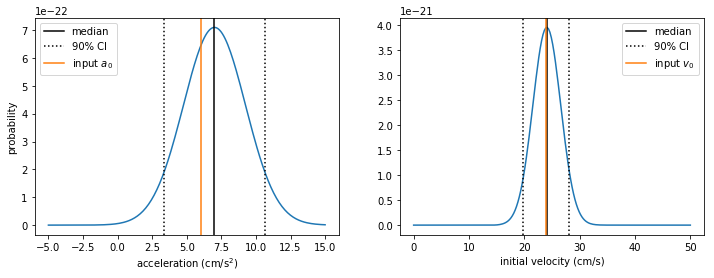

In [17]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.plot(As, apost)
ax1.set_xlabel("acceleration (cm/s$^2$)")
ax1.axvline(x=a_med, color = 'k', label='median')
ax1.axvline(x=a_5, color = 'k', linestyle=':', label=r'90% CI')
ax1.axvline(x=a_95, color = 'k', linestyle=':')
ax1.axvline(x=a0, color = 'C1', label='input $a_0$')
ax1.set_ylabel('probability')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(vs, vpost)
ax2.set_xlabel("initial velocity (cm/s)")
ax2.axvline(x=v_med, color = 'k', label='median')
ax2.axvline(x=v_5, color = 'k', linestyle=':', label=r'90% CI')
ax2.axvline(x=v_95, color = 'k', linestyle=':')
ax2.axvline(x=v0, color = 'C1', label='input $v_0$')
ax2.legend();

## best fit quadratic

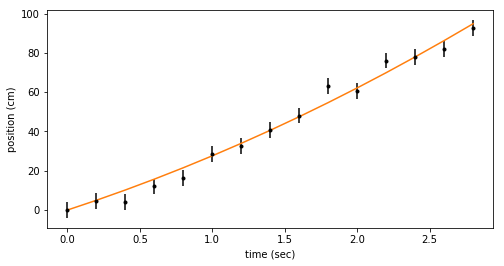

In [18]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.errorbar(ts, x_dat, yerr=dx, fmt=".k")
ax.plot(ts, bestfit_quad, color='C1')
ax.set_xlabel('time (sec)')
ax.set_ylabel('position (cm)');

In [19]:
print(Odds, prob)
print(v_med, v_5-v_med, v_95-v_med)
print(a_med, a_5-a_med, a_95-a_med)

36.40104377755644 0.9732627782810682
24.120603015075375 -4.271356783919597 4.0201005025125625
6.959798994974875 -3.618090452261306 3.7185929648241203


## For your abstract

Acceleration was favored over constant velocity with a Bayes factor of 33, corresponding to 97% probability.

We measured $v_0 = 24.1^{+4.0}_{-4.3}$ cm/s and $a_0 = 7.0^{+3.7}_{-3.6}$ cm/s$^2$, where ranges represent 90% credible intervals.

## compare line and quadratic

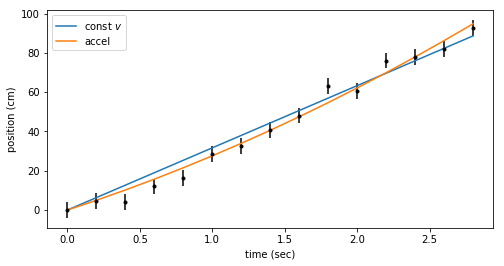

In [20]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.errorbar(ts, x_dat, yerr=dx, fmt=".k")
ax.plot(ts, bestfit_line, color='C0', label='const $v$')
ax.plot(ts, bestfit_quad, color='C1', label='accel')
ax.set_xlabel('time (sec)')
ax.set_ylabel('position (cm)')
ax.legend();